In [1]:
import numpy as np 
import pandas as pd
import os
import psycopg2
import geopandas as gpd

import importlib
from Secrets import secrets
# importlib.reload(secrets)

import matplotlib.pyplot as plt
import seaborn as sns

# Is there sufficient evidence to suggest price per sqm is higher for property with better energy efficiency rating?

In [76]:
# Get Data
# When extracting and calculating price per sq meter
# Try to create a sample of identical properties (as much as possible) because we want to make sure price is not impacted by those characteristics 
# Extract the properties with those specifications:
# - Leaseholds only
# - 3 beds
# - Flats
# - Not new build 
# - Energy efficiency C
# - Construction years 1900-1929


engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
cur = engine.cursor()
cur.execute("""
SELECT 
    p.brn, p.year, e.total_floor_area, e.construction_age_band, e.current_energy_efficiency, 
    e.potential_energy_efficiency, e.potential_energy_rating,
    ROUND( ((CAST(potential_energy_efficiency as float) - CAST(current_energy_efficiency as float) )/CAST(potential_energy_efficiency as float))::numeric, 1) as diff,
    CAST(ROUND((p.price)::numeric, 0 ) as integer) as avg_price,
    CAST(ROUND((p.price/e.total_floor_area)::numeric, 3 ) as integer) as sqm_price
    
from prices as p
join epc as e
on e.brn = p.brn

where e.total_floor_area <> 0 and e.number_habitable_rooms <> 0 and e.number_habitable_rooms is not null and e.total_floor_area is not null
and (e.total_floor_area > 60 and e.total_floor_area < 75)
and e.number_habitable_rooms = 3
and p.type = 'F'
and p.duration = 'L'
and p.new = 'N'
and e.potential_energy_rating = 'C'
and e.construction_age_band = '1900-1929'
and p.year in (2017, 2018, 2019, 2020)
and p.district = 'LAMBETH';

""")
rows = cur.fetchall()
result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
result["diff"] = [str(x) for x in result["diff"]]
result.head()

,brn,year,total_floor_area,construction_age_band,current_energy_efficiency,potential_energy_efficiency,potential_energy_rating,diff,avg_price,sqm_price
0,3.227192e+09,2018.0,63.00,1900-1929,62,74,C,0.2,385500,6119
1,1.266158e+09,2020.0,65.00,1900-1929,65,78,C,0.2,370000,5692
2,4.642248e+09,2020.0,72.00,1900-1929,55,79,C,0.3,590000,8194
3,4.642248e+09,2018.0,72.00,1900-1929,55,79,C,0.3,556500,7729
4,6.573246e+09,2019.0,70.89,1900-1929,69,69,C,0.0,275000,3879


In [77]:
# Explain sample
print( f"There are {str(len(result['brn'].unique()))} properties in the sample \n")

print("13% of properties within less than 5%, 42% of properties sold are within 10%, 31% within 20% from their potential energy efficiency")
print(round(result["diff"].value_counts()/(result.shape[0]), 2).head(5))

print("\n Average price per sq meter looks different depending on how far current energy efficiency is from potential")
print(result.groupby("diff", as_index=False).agg({"sqm_price": "mean", "brn": "count"}).round().head())

There are 256 properties in the sample 

13% of properties within less than 5%, 42% of properties sold are within 10%, 31% within 20% from their potential energy efficiency
0.1    0.31
0.2    0.28
0.0    0.24
0.3    0.13
0.4    0.02
Name: diff, dtype: float64

 Average price per sq meter looks different depending on how far current energy efficiency is from potential
  diff  sqm_price  brn
0  0.0     7193.0   73
1  0.1     7707.0   96
2  0.2     7183.0   87
3  0.3     7116.0   40
4  0.4     7364.0    6


/home/elena/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/elena/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


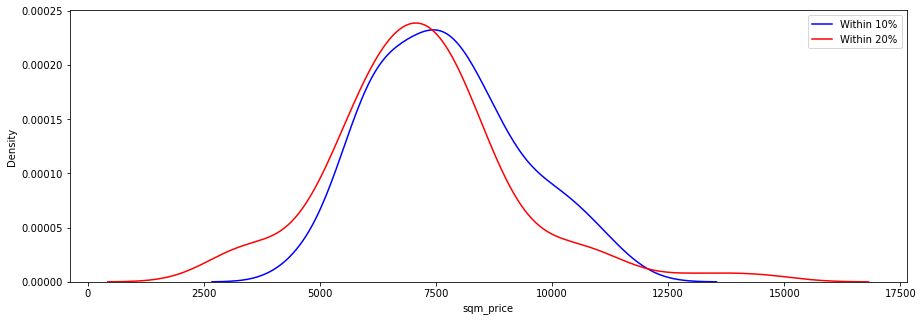

In [81]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.distplot(result[result["diff"] == '0.1']["sqm_price"], hist=False, color ="blue", label="Within 10%")
sns.distplot(result[result["diff"] == '0.2']["sqm_price"], hist=False, color="red", label="Within 20%")
plt.legend()
plt.show()

In [96]:
# Statistical Test (Test of difference in means)
# Test
# Ho = mean1-mean2=0
# H1 = mean1-mean2!=0

# Variables
diff_mean = result[result["diff"].isin(['0.1'])]["sqm_price"].mean() - result[result["diff"].isin(['0.2'])]["sqm_price"].mean()
mean_all = result[result["diff"].isin(['0.1', '0.2'])]["sqm_price"].mean()
stdev_all = result[result["diff"].isin(['0.1', '0.2'])]["sqm_price"].std()
print(f"Mean of {mean_all} and st dev of {stdev_all} and diff in mean {diff_mean} \n")
print(f"Z score {diff_mean/stdev_all} is too low and insufficient to reject H0 \n")
print("The price per sqm in Lambeth area is not significantly different weather property is within 5% or 20% of its potential energy efficiency")

Mean of 7458.081967213115 and st dev of 1778.882239136978 and diff in mean 523.827227011494 

Z score 0.2944698729836259 is too low and insufficient to reject H0 

The price per sqm in Lambeth area is not significantly different weather property is within 5% or 20% of its potential energy efficiency


# Is there sufficient evidence to suggest price per sqm is higher for property built in specific period

In [ ]:
# Assume the experiment is to have identical properties (as much as possible) however some build in one period and another in different period
# Does the price per sqm differs based on which period property was build in?
#

In [100]:
# Get Data
# When extracting and calculating price per sq meter
# Try to create a sample of identical properties (as much as possible) because we want to make sure price is not impacted by those characteristics 
# Extract the properties with those specifications:
# - Leaseholds only
# - 3 beds
# - Flats
# - Not new build 
# - Energy efficiency C
# - Construction years 1900-1929


engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
cur = engine.cursor()
cur.execute("""
SELECT 
    p.brn, p.year, e.total_floor_area, e.construction_age_band, e.current_energy_efficiency, 
    e.potential_energy_efficiency, e.potential_energy_rating,
    ROUND( ((CAST(potential_energy_efficiency as float) - CAST(current_energy_efficiency as float) )/CAST(potential_energy_efficiency as float))::numeric, 1) as diff,
    CAST(ROUND((p.price)::numeric, 0 ) as integer) as avg_price,
    CAST(ROUND((p.price/e.total_floor_area)::numeric, 3 ) as integer) as sqm_price
    
from prices as p
join epc as e
on e.brn = p.brn

where e.total_floor_area <> 0 and e.number_habitable_rooms <> 0 and e.number_habitable_rooms is not null and e.total_floor_area is not null
and (e.total_floor_area > 60 and e.total_floor_area < 75)
and e.number_habitable_rooms = 3
and p.type = 'F'
and p.duration = 'L'
and p.new = 'N'
and e.potential_energy_rating = 'C'
and e.construction_age_band in ('before 1900', '1900-1929')
and p.year in (2017, 2018, 2019, 2020)
and p.district = 'LAMBETH'
and ROUND( ((CAST(potential_energy_efficiency as float) - CAST(current_energy_efficiency as float) )/CAST(potential_energy_efficiency as float))::numeric, 1) < 0.3;

""")
rows = cur.fetchall()
result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
result.head()

,brn,year,total_floor_area,construction_age_band,current_energy_efficiency,potential_energy_efficiency,potential_energy_rating,diff,avg_price,sqm_price
0,8.557349e+09,2017.0,70.30,before 1900,68,69,C,0.0,630000,8962
1,2.636059e+09,2018.0,64.00,before 1900,57,72,C,0.2,567000,8859
2,3.227192e+09,2018.0,63.00,1900-1929,62,74,C,0.2,385500,6119
3,6.573246e+09,2019.0,70.89,1900-1929,69,69,C,0.0,275000,3879
4,1.266158e+09,2020.0,65.00,1900-1929,65,78,C,0.2,370000,5692


In [101]:
result["construction_age_band"].value_counts()

1900-1929      256
before 1900    159
Name: construction_age_band, dtype: int64

In [ ]:

# Is there sufficient evidence to suggest price per sqm is higher for older property not new?